## Import Libraries

In [0]:
import pandas as pd
import numpy as np
from keras import Sequential, layers
from keras.optimizers import Adam
from keras.datasets import cifar10
from keras.layers import Conv2D,LeakyReLU,MaxPooling2D,Flatten,Dense,Reshape,Conv2DTranspose, Input
import matplotlib.pyplot as plt
from keras import initializers
from keras.models import Model
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.utils import to_categorical


Using TensorFlow backend.


## Functions to read data and preprocessing

In [0]:
# This function for grouping values by timestamp and reshaping is imported from github:
 # https://github.com/vanduc103/air_analysis_v1/blob/master/convolutional.py

def read_data(data_file,aqi_file):
    N = 1024 # number of cells
    timerange_init = -1
    X = list()
    # read pm2_5 values
    with open(data_file, 'r') as f:
        next(f) # by pass the header
        for row in f:
            res = row.split(',')
            timerange, map_idx, pm2_5 = int(res[0]), int(res[1]), float(res[2])
            # create list of pm2_5
            if (timerange != timerange_init):
                x1 = list()
                for j in range(N):
                    x1.append(0)
                timerange_init = timerange
                X.append(x1)
            else:
                x1 = X[timerange]
            x1[map_idx] = pm2_5
    Y = list()
    with open(aqi_file, 'r') as f:
        for row in f:
            Y.append(float(row))

    # show values
    m = timerange + 1
    X = np.asarray(X)
    X = X.reshape(m, 32, 32, 1)
    Y = np.asarray(Y)
    Y = Y[0:m]
    y_ = np.copy(Y)
    y_[np.argwhere(Y <= 15)[:,0]] = 0
    y_[np.argwhere(np.logical_and(Y > 15, Y <= 35))[:,0]] = 1
    y_[np.argwhere(np.logical_and(Y > 35, Y <= 75))[:,0]] = 2
    y_[np.argwhere(Y > 75)[:,0]] = 3

    return X, y_       


## Build CNN model

In [0]:
def buildCNN(inp_dim):
    model = Sequential()
    #1
    model.add(Conv2D(32,kernel_size=5,strides=(1,1),padding='SAME', input_shape = inp_dim))
    model.add(LeakyReLU(0.2))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    #2
    model.add(Conv2D(32,kernel_size=5,strides=(1,1),padding='SAME'))
    model.add(LeakyReLU(0.2))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    #3
    model.add(Flatten())
    model.add(Dense(364))
    model.add(Dense(192))
    model.add(Dense(4,activation='softmax'))

    model.compile(Adam(lr=0.0001), loss='categorical_crossentropy',
                    metrics=['accuracy'])
    return model

## Read training data 

In [0]:
#Read data from 4 files
x1,y1 = read_data('data_12_2017.csv','aqi_12_2017')
x2,y2 = read_data('data_11_2017.csv','aqi_11_2017')
x3,y3 = read_data('data_10_2017.csv','aqi_10_2017')
x4,y4 = read_data('data_09_2017.csv','aqi_09_2017')

#Concatenate all data
X_train = np.concatenate([x1, x2, x3, x4], axis = 0)
y_train = np.concatenate([y1, y4, y3, y4], axis = 0)

#Split to training and validation.
split_size = int(X_train.shape[0]*0.9)
train_x, val_x = X_train[:split_size], X_train[split_size:]
train_y= y_train[:split_size]
val_y  = y_train[split_size:]

#Read test data
X_test, y_test = read_data('data_01_2018.csv', 'aqi_01_2018')
inp_dim = X_train[0].shape

train_x[0].shape


In [0]:
#Build CNN model
model = buildCNN(inp_dim)

#Make tensorboard object
tensorboard = TensorBoard(
  log_dir='/content/drive/My Drive/DLProject1/cnn_ap3',
  histogram_freq=0,
  batch_size=64,
  write_graph=True,
  write_grads=True
)
tensorboard.set_model(model)

## Start Training

In [0]:
#Training from scratch

batch_size = 64
epochs = 200
seed = 128
rng = np.random.RandomState(seed)
for i in range(0,epochs):
    total_batch = len(train_x)//batch_size
    for j in range(total_batch):
        batch_mask = rng.choice(train_x.shape[0], batch_size)
        batch_x = train_x[[batch_mask]]
        batch_y = train_y[[batch_mask]]    
        batch_y = to_categorical(batch_y,4)
        loss = model.train_on_batch(batch_x,batch_y)
    tensorboard.on_epoch_end(i, {"loss":loss[0],"acc":loss[1]}) 
    print(' ***epoch '+str(i)+ ' '+str(loss) ) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



 ***epoch 0 [1.4521585, 0.3125]
 ***epoch 1 [1.0232806, 0.515625]
 ***epoch 2 [1.3713073, 0.515625]
 ***epoch 3 [0.90282404, 0.65625]
 ***epoch 4 [0.9550656, 0.640625]
 ***epoch 5 [1.0990579, 0.625]
 ***epoch 6 [0.72208405, 0.75]
 ***epoch 7 [0.78507686, 0.8125]
 ***epoch 8 [0.80089706, 0.84375]
 ***epoch 9 [0.56494963, 0.859375]
 ***epoch 10 [0.47486997, 0.859375]
 ***epoch 11 [0.5986959, 0.765625]
 ***epoch 12 [0.36846927, 0.890625]
 ***epoch 13 [0.38962513, 0.828125]
 ***epoch 14 [0.39711004, 0.84375]
 ***epoch 15 [0.3841864, 0.890625]
 ***epoch 16 [0.2976397, 0.9375]
 ***epoch 17 [0.28493646, 0.90625]
 ***epoch 18 [0.3129053, 0.890625]
 ***epoch 19 [0.31272197, 0.875]
 ***epoch 20 [0.513276, 0.890625]
 ***epoch 21 [0.22959039, 0.921875]
 ***epoch 22 [0.2321307, 0.921875]
 ***epoch 23 [0.19477819, 0.96875]
 ***epoch 24 [0.1906231, 0.953125]
 ***epoch 25 [0.2716744, 0.90625]
 ***epoch 26 [0.2193717, 0.9375]
 ***epoch 27 [0.11591697, 1.0]
 ***epoch 28 [0.19199553, 0.9375]
 ***epoch 2

In [0]:
#train_y = to_categorical(train_y,4)
#model = buildCNN(inp_dim)
# history = model.fit(train_x,train_y,epochs=100,batch_size=64,
#           callbacks =[tensorboard])

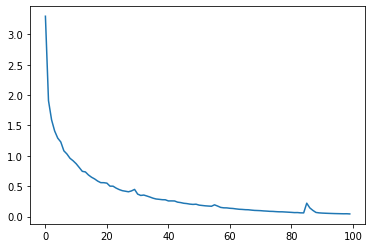

In [0]:
plt.plot(history.history['loss'])
plt.show()

## Spatial distribution vs Predicted values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after removing the cwd from sys.path.


(1, 4)
 
(1, 4)
 
(1, 4)
 
(1, 4)
 


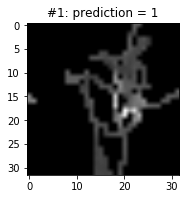

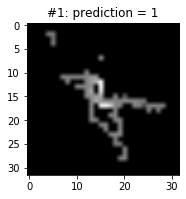

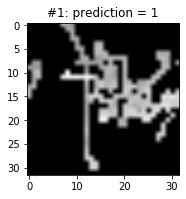

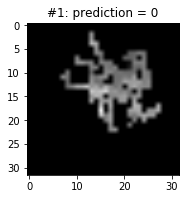

In [0]:
#4 Random samples
for j in range(4):
    batch_mask = rng.choice(X_test.shape[0], 1)
    batch_x = X_test[[batch_mask]]
    batch_y = y_test[[batch_mask]]
    y = model.predict(batch_x)
    fig = plt.figure()
    ax = fig.add_subplot(121)
    ax.set_title('#' + str(1) + ': prediction = ' + str(np.argmax(y)))
    ax.imshow(batch_x[0][:,:,0], cmap='gray', interpolation='bilinear')
    print(' ')

## Evaluate model

In [0]:
X_test, y_test = read_data('data_01_2018.csv', 'aqi_01_2018')
y_test = to_categorical(y_test,4)
model.evaluate(X_test,y_test)

404/404 [==============================] - 0s 194us/step


[5.959045034824031, 0.4331683162415382]

## Count values for each class

In [0]:
y = model.predict(X_test)
good = 0
moderate = 0
unheaelthy = 0
hazardous  = 0
corr = 0
for i in range(len(y_test)):
  val = np.argmax(y[i])
  if val==0:
    good=good+1
  elif val==1:
    moderate=moderate+1
  elif val==2:
    unheaelthy=unheaelthy+1
  else:
    hazardous = hazardous + 1
    

## Print values for each class

In [0]:
print('Good = '+str(good))
print('Moderate = '+str(moderate))
print('Uhealthy = '+ str(unheaelthy))
print('Hazardous = '+ str(hazardous))

Good = 153
Moderate = 191
Uhealthy = 60
Hazardous = 0
